<a href="https://colab.research.google.com/github/kt515/Data-Science-Projects/blob/main/Attendance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Statement

Due to this pandemic, all CCA activities are now conducted online. While it has brought some people convenience by being able to attend CCA sessions virtually, it has created many unforeseen problems. It has now become easier for participants to register for many events but not show up in the end.

Using the registration data provided, how can we rank returning members and predict their possible turnout rate?

In [ ]:
!pip install -U -q PyDrive # remember to install pydrive if not done yet!
!pip install xgboost

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Classif Libraries & metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## Read Dataset


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = '1KdGuyqJIgNCnmi9We9rqMXLP7EGO_wPq' # shareable link

In [ ]:
downloaded = drive.CreateFile({'id':link}) 
downloaded.GetContentFile('DAC_Attendance.csv')  
df = pd.read_csv('DAC_Attendance.csv',header = 0)
# Dataset is stored as a pd.Dataframe

In [ ]:
df.head()

,SIM ID,Name,School,Courses,Positions,Number of CCAS,Attendance
0,1015164.0,Maggi Marriner,UoL,Social science/arts,Exco,1,1
1,1014337.0,Melvyn Loody,Sterling,Social science/arts,Exco,2,1
2,1012841.0,Noelyn Bortolazzi,UoW,Social science/arts,Exco,3,1
3,1019383.0,Lita Iacomini,UoW,Tech,Exco,1,1
4,1016356.0,Dom Fairweather,UoW,Tech,Exco,1,1


In [ ]:
unique_schools = df['School'].unique()
unique_courses = df['Courses'].unique()
print(unique_schools,unique_courses)

['UoL' 'Sterling' 'UoW' 'RMIT' 'Global' 'UB'] ['Social science/arts' 'Tech' 'Business']


## Data Cleaning
- Remove NA values
- Convert data types
- Replace all 0 CCA with 1 CCA 
- Standardize School Names

#### Remove NA

In [ ]:
df.isna().sum() # 2 NA values in "SIM ID" column

SIM ID            2
Name              0
School            0
Courses           0
Positions         0
Number of CCAS    0
Attendance        0
dtype: int64

In [ ]:
df[df.isnull().any(axis=1)] # rows with missing SIM ID

,SIM ID,Name,School,Courses,Positions,Number of CCAS,Attendance
9,NaN,Mandel MacDuffie,RMIT,Tech,Sub-comm,2,1
108,NaN,Juan Scott,Sterling,Business,Others,1,1


In [ ]:
df = df.dropna() # drop NA rows
df.isna().sum()

SIM ID            0
Name              0
School            0
Courses           0
Positions         0
Number of CCAS    0
Attendance        0
dtype: int64

#### Convert data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SIM ID          198 non-null    float64
 1   Name            198 non-null    object 
 2   School          198 non-null    object 
 3   Courses         198 non-null    object 
 4   Positions       198 non-null    object 
 5   Number of CCAS  198 non-null    int64  
 6   Attendance      198 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 12.4+ KB


In [ ]:
df['SIM ID'] = df['SIM ID'].astype(int) # convert SIM ID to integer

#### Replace all 0 CCA with 1 CCA

In [ ]:
df['Number of CCAS'].value_counts() # number of 0 CCAs should be none as everyone should have DAC as a CCA

1    135
2     48
3     11
4      2
0      2
Name: Number of CCAS, dtype: int64

In [ ]:
df['Number of CCAS'] = df['Number of CCAS'].replace(0,1)
df['Number of CCAS'].value_counts() # all 0 CCAs removed

1    137
2     48
3     11
4      2
Name: Number of CCAS, dtype: int64

Standardize School Names


In [ ]:
df['School'] = df['School'].str.upper() # Change all to uppercase
df['School']

0           UOL
1      STERLING
2           UOW
3           UOW
4           UOW
         ...   
195        RMIT
196         UOL
197        RMIT
198      GLOBAL
199        RMIT
Name: School, Length: 198, dtype: object

## Data Transformation
- Introduce a new feature "Relative registered duration" - smaller values signify that student has been in the school for a long time

Since SIM ID are consequtively getting bigger as the years increase, students with bigger SIMID have registered later than their counterparts with a smaller SIM ID. 



In [ ]:
df['Relative registered duration'] = df['SIM ID'] - 1000000 # the intial "10XXXXX" is redundant

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Relative registered duration'] = scaler.fit_transform(df[['Relative registered duration']])
#df['Number of CCAS'] = scaler.fit_transform(df[['Number of CCAS']])
print(df['Relative registered duration']) # values of "relative registered duration" is scaled between 0 to 1 

0      0.323036
1      0.270899
2      0.176586
3      0.589018
4      0.398184
         ...   
195    0.830349
196    0.632140
197    0.104463
198    0.167633
199    0.735216
Name: Relative registered duration, Length: 198, dtype: float64


## Data transformation for ML
I've encoded the categorical data here

In [ ]:
df1 = pd.get_dummies(df, columns=['School','Courses','Positions'],drop_first=True)
df1.head()
# df1 is the transformed dataest for ML, df is the orignal dataset

,SIM ID,Name,Number of CCAS,Attendance,Relative registered duration,School_RMIT,School_STERLING,School_UB,School_UOL,School_UOW,Courses_Social science/arts,Courses_Tech,Positions_Others,Positions_Sub-comm
0,1015164,Maggi Marriner,1,1,0.323036,0,0,0,1,0,1,0,0,0
1,1014337,Melvyn Loody,2,1,0.270899,0,1,0,0,0,1,0,0,0
2,1012841,Noelyn Bortolazzi,3,1,0.176586,0,0,0,0,1,1,0,0,0
3,1019383,Lita Iacomini,1,1,0.589018,0,0,0,0,1,0,1,0,0
4,1016356,Dom Fairweather,1,1,0.398184,0,0,0,0,1,0,1,0,0


In [ ]:
# Transforming categorical data into numerical data to be fed into ML models
df['Courses coded'] = pd.Categorical(df['Courses'])
for course,index in zip(df['Courses'].unique(),np.arange(1,4)):
    df['Courses coded'] = df['Courses coded'].replace(course,index)

df['School coded'] = pd.Categorical(df['School'])
for School,index in zip(df['School'].unique(),np.arange(1,7)):
    df['School coded'] = df['School coded'].replace(School,index)

df['Positions coded'] = pd.Categorical(df['Positions'])
for Positions,index in zip(df['Positions'].unique(),np.arange(1,4)):
    df['Positions coded'] = df['Positions coded'].replace(Positions,index)
df.head()

,SIM ID,Name,School,Courses,Positions,Number of CCAS,Attendance,Relative registered duration,Courses coded,School coded,Positions coded
0,1015164,Maggi Marriner,UOL,Social science/arts,Exco,1,1,0.323036,1,1,1
1,1014337,Melvyn Loody,STERLING,Social science/arts,Exco,2,1,0.270899,1,2,1
2,1012841,Noelyn Bortolazzi,UOW,Social science/arts,Exco,3,1,0.176586,1,3,1
3,1019383,Lita Iacomini,UOW,Tech,Exco,1,1,0.589018,2,3,1
4,1016356,Dom Fairweather,UOW,Tech,Exco,1,1,0.398184,2,3,1


In [ ]:
# filtering only numerical columns to fit into model
numeric_df = df.drop(columns = ['SIM ID', 'Name', 'School', 'Courses', 'Positions'])
numeric_df.head()
numeric_df.dtypes

Number of CCAS                     int64
Attendance                         int64
Relative registered duration     float64
Courses coded                   category
School coded                    category
Positions coded                 category
dtype: object

In [ ]:
# Convert Categorical data into numerical to fit into models and visualization
columns_to_select = ['Courses coded', 'School coded', 'Positions coded']
numeric_df[columns_to_select] = numeric_df[columns_to_select].apply(pd.to_numeric, errors='coerce', axis=1)
numeric_df.dtypes

Number of CCAS                    int64
Attendance                        int64
Relative registered duration    float64
Courses coded                     int64
School coded                      int64
Positions coded                   int64
dtype: object

<Figure size 288x216 with 0 Axes>

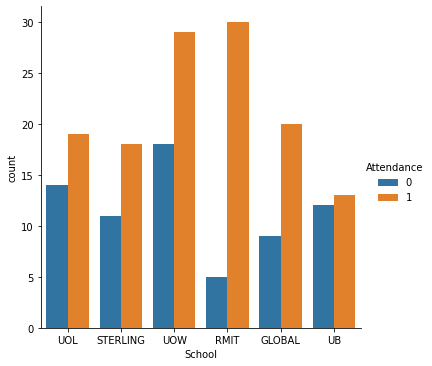

In [ ]:
# incase yall okay with this :p
plt.figure(figsize=(4, 3))
plot = sns.catplot(data=df ,kind="count", x="School",hue="Attendance")

<Figure size 288x216 with 0 Axes>

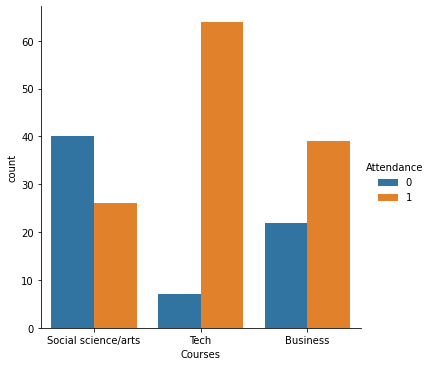

In [ ]:
plt.figure(figsize=(4, 3))
plot = sns.catplot(data=df ,kind="count", x="Courses",hue="Attendance")

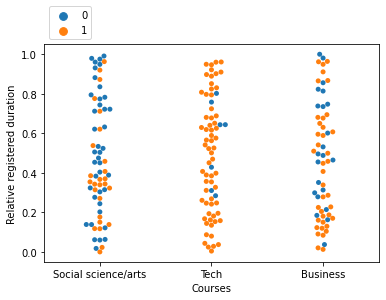

In [ ]:
columns = df.iloc[:,[5,7,8,9,10]]
sns.swarmplot(x="Courses", y="Relative registered duration", hue="Attendance",data = df)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)

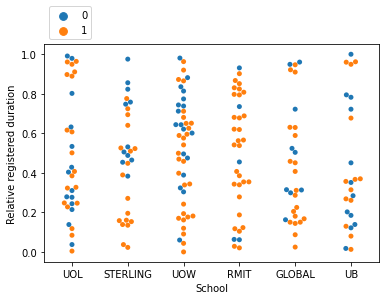

In [ ]:
columns = df.iloc[:,[5,7,8,9,10]]
sns.swarmplot(x="School", y="Relative registered duration", hue="Attendance",data = df)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)

In [ ]:
Index = ["Number of CCAS","Relative registered duration",	"Courses coded",	"School coded",	"Positions coded"]
Cols = ["Attendance"]
table = DataFrame(abs(np.random.randn(5,1)), index = Index,columns = Cols)

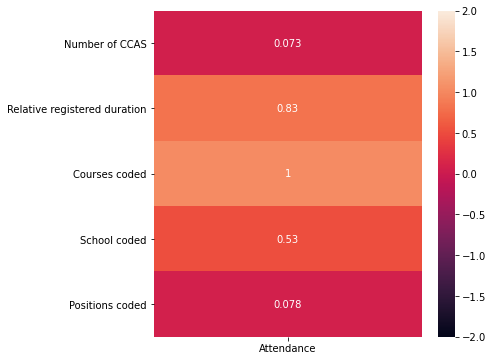

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(table,vmin=-2,vmax=2,annot=True)

In [ ]:
# Selecting features, splitting into x and y

col_list = [] #explanatory variables, x
for col in df1:
    if col not in ['Attendance','SIM ID','Name']:
      col_list.append(col)
print(col_list) 

df_x = df1[col_list]
df_y = df1['Attendance']

df_x.head()

['Number of CCAS', 'Relative registered duration', 'School_RMIT', 'School_STERLING', 'School_UB', 'School_UOL', 'School_UOW', 'Courses_Social science/arts', 'Courses_Tech', 'Positions_Others', 'Positions_Sub-comm']


,Number of CCAS,Relative registered duration,School_RMIT,School_STERLING,School_UB,School_UOL,School_UOW,Courses_Social science/arts,Courses_Tech,Positions_Others,Positions_Sub-comm
0,1,0.323036,0,0,0,1,0,1,0,0,0
1,2,0.270899,0,1,0,0,0,1,0,0,0
2,3,0.176586,0,0,0,0,1,1,0,0,0
3,1,0.589018,0,0,0,0,1,0,1,0,0
4,1,0.398184,0,0,0,0,1,0,1,0,0


In [ ]:
# Selecting features, splitting into x and y

col_list = [] #explanatory variables, x
for col in numeric_df:
    if col != 'Attendance': 
        col_list.append(col)
print(col_list) 

df_x = numeric_df[col_list]
df_y = numeric_df['Attendance']

df_x.head()

['Number of CCAS', 'Relative registered duration', 'Courses coded', 'School coded', 'Positions coded']


,Number of CCAS,Relative registered duration,Courses coded,School coded,Positions coded
0,1,0.323036,1,1,1
1,2,0.270899,1,2,1
2,3,0.176586,1,3,1
3,1,0.589018,2,3,1
4,1,0.398184,2,3,1


In [ ]:
# Train,Test, Split
x_train, x_test, y_train, y_test = train_test_split(df_x, 
                                                    df_y, 
                                                    test_size=0.20, # 20% Testing Data
                                                    random_state=10)

display(x_train.head())
display(y_train.head())

,Number of CCAS,Relative registered duration,School_RMIT,School_STERLING,School_UB,School_UOL,School_UOW,Courses_Social science/arts,Courses_Tech,Positions_Others,Positions_Sub-comm
190,1,0.501198,0,0,0,1,0,0,1,1,0
7,1,0.775879,0,1,0,0,0,1,0,0,1
27,1,0.161707,0,0,0,0,1,0,1,0,1
138,1,0.389358,0,1,0,0,0,0,1,1,0
59,1,0.247762,0,0,0,1,0,0,1,1,0


190    1
7      1
27     1
138    1
59     1
Name: Attendance, dtype: int64

## Logistic Regression

Accuracy: 0.8 

              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.92      0.79      0.85        29

    accuracy                           0.80        40
   macro avg       0.76      0.81      0.77        40
weighted avg       0.83      0.80      0.81        40



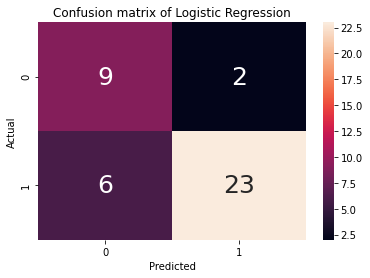

In [ ]:
# fit model
logisticRegr = LogisticRegression()

logisticRegr = logisticRegr.fit(x_train, y_train)
results = logisticRegr.predict(x_test)

cm = confusion_matrix(y_test, results)
lr_acc = accuracy_score(y_test, results)
print("Accuracy:", lr_acc, "\n")
print(classification_report(y_test, results))

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Logistic Regression")
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
plt.show()

## Ranking of members

In [ ]:
prob_results = logisticRegr.predict_proba(df_x)
df['prob_of_attendance'] = prob_results[:,1]

In [ ]:
df_sorted = df.sort_values(by=['prob_of_attendance'], ascending=False)
df_sorted = df_sorted[['SIM ID','Name','prob_of_attendance']].reset_index().drop('index',axis=1)
df_sorted.head()

,SIM ID,Name,prob_of_attendance
0,1010490,Annice Lidington,0.998756
1,1022683,Madlen Lyver,0.997169
2,1012605,Binny Abbys,0.994736
3,1012921,Daron Mallya,0.994623
4,1015658,Berrie Sahnow,0.993936


## Random Forest

Accuracy: 0.825 

              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.92      0.83      0.87        29

    accuracy                           0.82        40
   macro avg       0.78      0.82      0.80        40
weighted avg       0.85      0.82      0.83        40



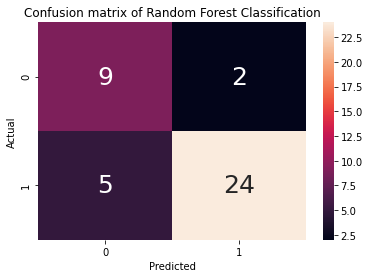

In [ ]:
rand = RandomForestClassifier()
rand = rand.fit(x_train, y_train)
results2 = rand.predict(x_test)

cm = confusion_matrix(y_test, results2)
rand_acc = accuracy_score(y_test, results2)
print("Accuracy:", rand_acc, "\n")
print(classification_report(y_test, results2))

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Random Forest Classification")
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
plt.show()

Text(0.5, 1.0, 'Feature Importance using Random Forest Classifier')

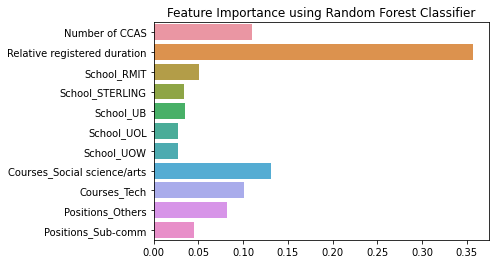

In [ ]:
feature_imp = rand.feature_importances_
g = sns.barplot(x=feature_imp, y=col_list) 
g.set_title('Feature Importance using Random Forest Classifier')

In [ ]:
prob_results_2 = rand.predict_proba(df_x)
df['prob_of_attendance'] = prob_results[:,1]

In [ ]:
df_sorted_2 = df.sort_values(by=['prob_of_attendance'], ascending=False)
df_sorted_2 = df_sorted[['SIM ID','Name','prob_of_attendance']].reset_index().drop('index',axis=1)
df_sorted_2.head()

,SIM ID,Name,prob_of_attendance
0,1010490,Annice Lidington,0.998756
1,1022683,Madlen Lyver,0.997169
2,1012605,Binny Abbys,0.994736
3,1012921,Daron Mallya,0.994623
4,1015658,Berrie Sahnow,0.993936


## XGBoost

Accuracy: 0.875 

              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.96      0.86      0.91        29

    accuracy                           0.88        40
   macro avg       0.84      0.89      0.85        40
weighted avg       0.89      0.88      0.88        40



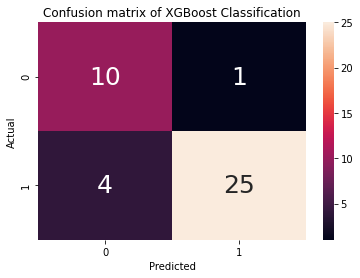

In [ ]:
xgb = XGBClassifier()
xgb = xgb.fit(x_train, y_train)
results3 = xgb.predict(x_test)

cm = confusion_matrix(y_test, results3)
xgb_acc = accuracy_score(y_test, results3)
print("Accuracy:", xgb_acc, "\n")
print(classification_report(y_test, results3))

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of XGBoost Classification")
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
plt.show()

Text(0.5, 1.0, 'Feature Importance using XGBoost')

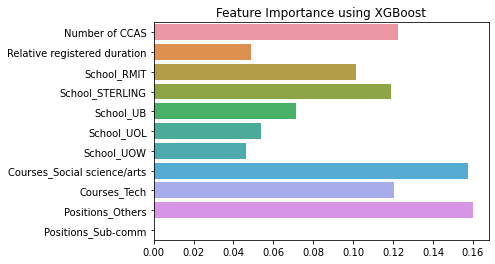

In [ ]:
g = sns.barplot(x=xgb.feature_importances_, y=col_list) 
g.set_title('Feature Importance using XGBoost')

In [ ]:
prob_results_3 = xgb.predict_proba(df_x)
df['prob_of_attendance'] = prob_results[:,1]

In [ ]:
df_sorted_3 = df.sort_values(by=['prob_of_attendance'], ascending=False)
df_sorted_3 = df_sorted[['SIM ID','Name','prob_of_attendance']].reset_index().drop('index',axis=1)
df_sorted_3.head()

,SIM ID,Name,prob_of_attendance
0,1010490,Annice Lidington,0.998756
1,1022683,Madlen Lyver,0.997169
2,1012605,Binny Abbys,0.994736
3,1012921,Daron Mallya,0.994623
4,1015658,Berrie Sahnow,0.993936


### LightGBM 

Accuracy: 0.85 

              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.96      0.83      0.89        29

    accuracy                           0.85        40
   macro avg       0.81      0.87      0.83        40
weighted avg       0.88      0.85      0.86        40



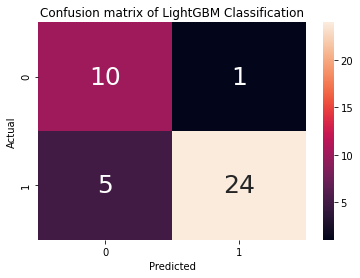

In [ ]:
lgbm = LGBMClassifier()
lgbm = lgbm.fit(x_train, y_train)
results4 = lgbm.predict(x_test)

cm = confusion_matrix(y_test, results4)
lgbm_acc = accuracy_score(y_test, results4)
print("Accuracy:", lgbm_acc, "\n")
print(classification_report(y_test, results4))

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of LightGBM Classification")
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
plt.show()

Text(0.5, 1.0, 'Feature Importance using LightGBM')

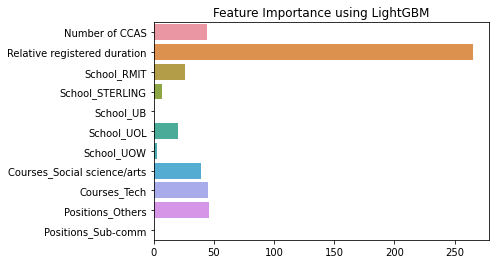

In [ ]:
g = sns.barplot(x=lgbm.feature_importances_, y=col_list) 
g.set_title('Feature Importance using LightGBM')

In [ ]:
prob_results_4 = lgbm.predict_proba(df_x)
df['prob_of_attendance'] = prob_results[:,1]

In [ ]:
df_sorted_4 = df.sort_values(by=['prob_of_attendance'], ascending=False)
df_sorted_4 = df_sorted[['SIM ID','Name','prob_of_attendance']].reset_index().drop('index',axis=1)
df_sorted_4.head()

,SIM ID,Name,prob_of_attendance
0,1010490,Annice Lidington,0.998756
1,1022683,Madlen Lyver,0.997169
2,1012605,Binny Abbys,0.994736
3,1012921,Daron Mallya,0.994623
4,1015658,Berrie Sahnow,0.993936


## KNN

Accuracy: 0.775 

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.86      0.83      0.84        29

    accuracy                           0.78        40
   macro avg       0.72      0.73      0.73        40
weighted avg       0.78      0.78      0.78        40



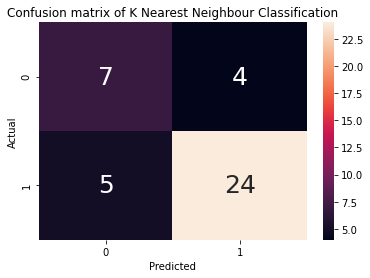

In [ ]:
knn = KNeighborsClassifier()
knn = knn.fit(x_train, y_train)
results5 = knn.predict(x_test)

cm = confusion_matrix(y_test, results5)
knn_acc = accuracy_score(y_test, results5)
print("Accuracy:", knn_acc, "\n")
print(classification_report(y_test, results5))

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of K Nearest Neighbour Classification")
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
plt.show()

In [ ]:
prob_results_5 = knn.predict_proba(df_x)
df['prob_of_attendance'] = prob_results[:,1]

In [ ]:
df_sorted_5 = df.sort_values(by=['prob_of_attendance'], ascending=False)
df_sorted_5 = df_sorted[['SIM ID','Name','prob_of_attendance']].reset_index().drop('index',axis=1)
df_sorted_5.head()

,SIM ID,Name,prob_of_attendance
0,1010490,Annice Lidington,0.998756
1,1022683,Madlen Lyver,0.997169
2,1012605,Binny Abbys,0.994736
3,1012921,Daron Mallya,0.994623
4,1015658,Berrie Sahnow,0.993936


In [ ]:
df = df.drop(['prob_of_attendance'],axis=1)